# Análisis Exploratorio
## Tema 13: Identificación de menciones de entidades biomédicas en resúmenes de investigación

Integrantes:
- José Ricardo Méndez González, 21289
- Sara María Pérez Echeverría, 21371
- Emily Elvia Melissa Pérez Alarcón, 21385
- Adrian Fulladolsa Palma, 21592

### Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Importación de los datos

In [2]:
# path de la data
data_path = '../data/'

# cargar data
abstracts_train = pd.read_csv(data_path + 'abstracts_train.csv', on_bad_lines='skip', delimiter='\t')
entities_train = pd.read_csv(data_path + 'entities_train.csv', on_bad_lines='skip', delimiter='\t')
relations_train = pd.read_csv(data_path + 'relations_train.csv', on_bad_lines='skip', delimiter='\t')
abstracts_test = pd.read_csv(data_path + 'abstracts_test.csv', on_bad_lines='skip', delimiter='\t')

### Resumen de los dataframes

In [10]:
def plot_non_null_proportions(df, title):
    # Calculate the proportion of non-null values
    non_null_proportions = df.notnull().mean() * 100
    
    # Plot the proportions
    plt.figure(figsize=(10, 6))
    non_null_proportions.plot(kind='bar', color='green')
    plt.title(f'Proportion of Non-Null Values in {title}')
    plt.ylabel('Percentage of Non-Null Values (%)')
    plt.xlabel('Columns')
    plt.ylim(0, 110)  # Keep it slightly above 100% for visual clarity
    plt.xticks(rotation=45, ha='right')
    plt.show()


Abstracts Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   abstract_id      400 non-null    int64 
 1   title            400 non-null    object
 2   abstract         400 non-null    object
 3   abstract_length  400 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.6+ KB
None


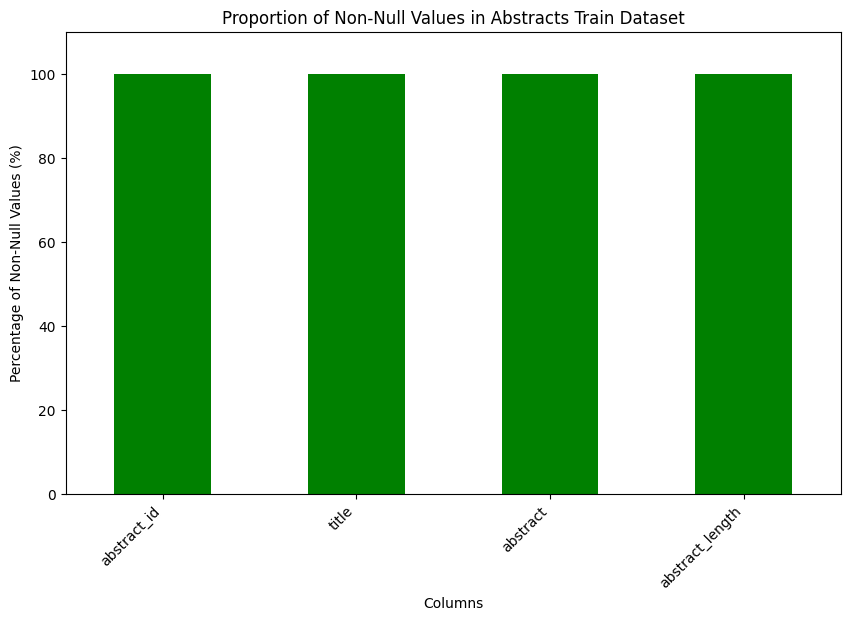


Entities Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             13636 non-null  int64 
 1   abstract_id    13636 non-null  int64 
 2   offset_start   13636 non-null  int64 
 3   offset_finish  13636 non-null  int64 
 4   type           13636 non-null  object
 5   mention        13636 non-null  object
 6   entity_ids     13636 non-null  object
dtypes: int64(4), object(3)
memory usage: 745.8+ KB
None


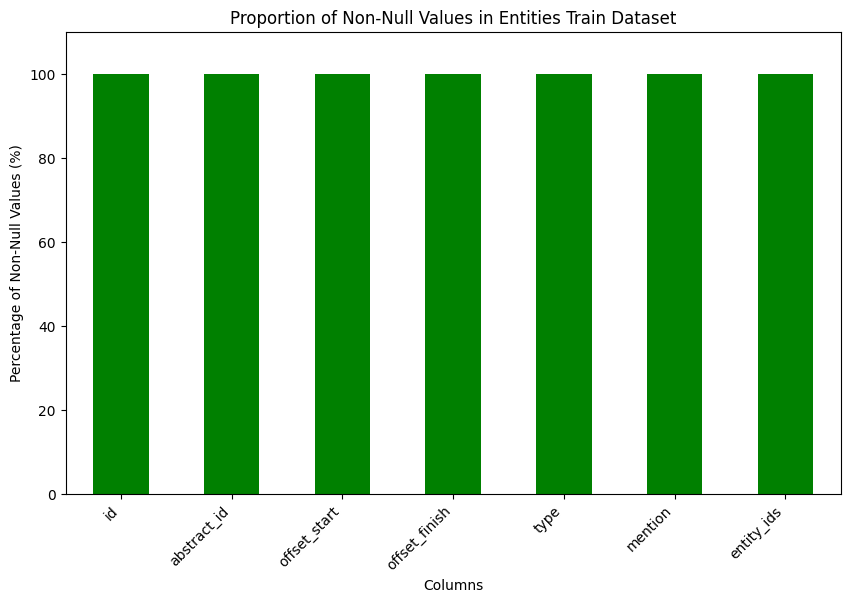


Relations Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           4280 non-null   int64 
 1   abstract_id  4280 non-null   int64 
 2   type         4280 non-null   object
 3   entity_1_id  4280 non-null   object
 4   entity_2_id  4280 non-null   object
 5   novel        4280 non-null   object
dtypes: int64(2), object(4)
memory usage: 200.8+ KB
None


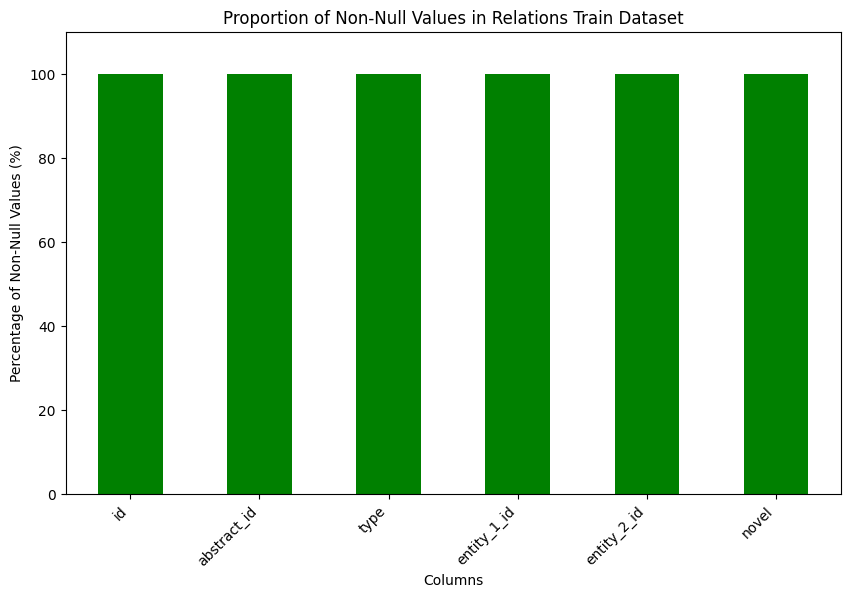


Abstracts Test Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   abstract_id  100 non-null    int64 
 1   title        100 non-null    object
 2   abstract     100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB
None


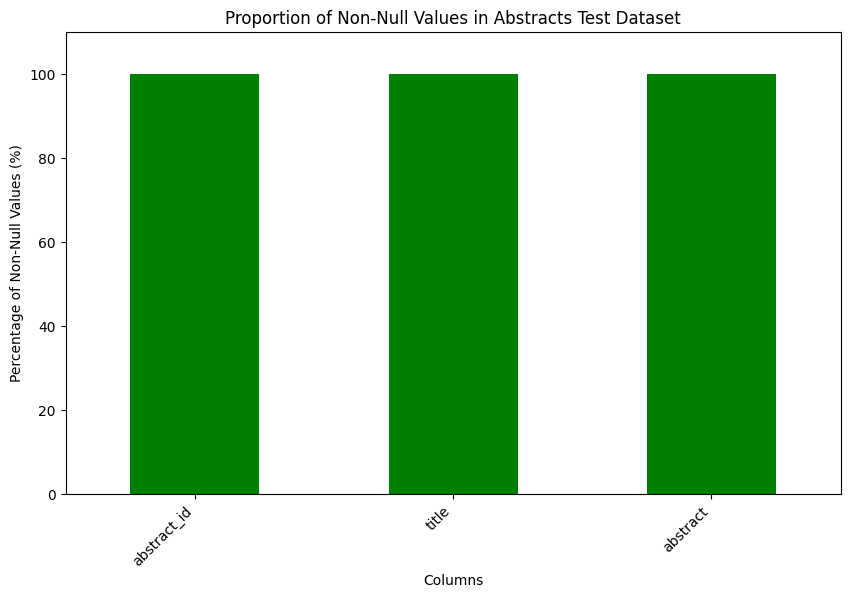

In [13]:
# resumen de los conjuntos de datos
print("Abstracts Train Dataset:")
print(abstracts_train.info())
plot_non_null_proportions(abstracts_train, "Abstracts Train Dataset")


print("\nEntities Train Dataset:")
print(entities_train.info())
plot_non_null_proportions(entities_train, "Entities Train Dataset")


print("\nRelations Train Dataset:")
print(relations_train.info())
plot_non_null_proportions(relations_train, "Relations Train Dataset")


print("\nAbstracts Test Dataset:")
print(abstracts_test.info())
plot_non_null_proportions(abstracts_test, "Abstracts Test Dataset")

### Exploración

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


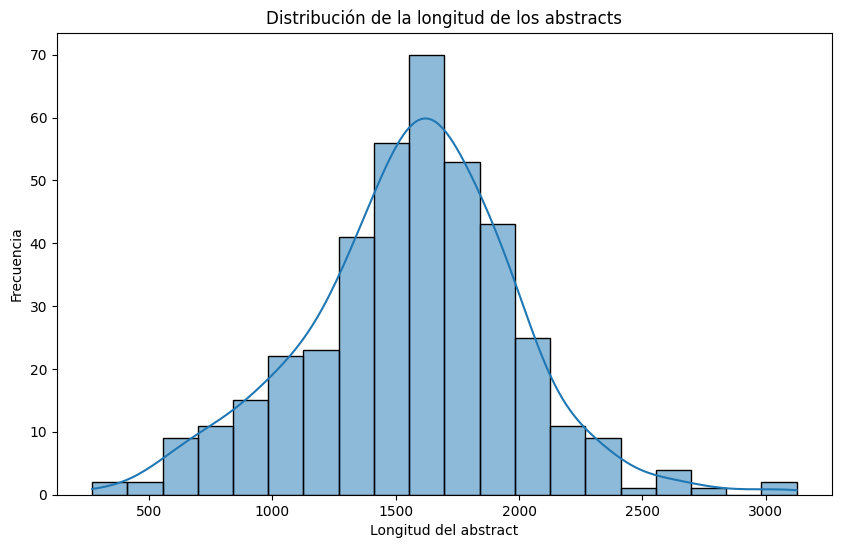

In [5]:
# analizar la longitud de los abstracts
abstracts_train['abstract_length'] = abstracts_train['abstract'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# visualizar la distribución de las longitudes de los abstracts
plt.figure(figsize=(10, 6))
sns.histplot(abstracts_train['abstract_length'], bins=20, kde=True)
plt.title("Distribución de la longitud de los abstracts")
plt.xlabel("Longitud del abstract")
plt.ylabel("Frecuencia")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


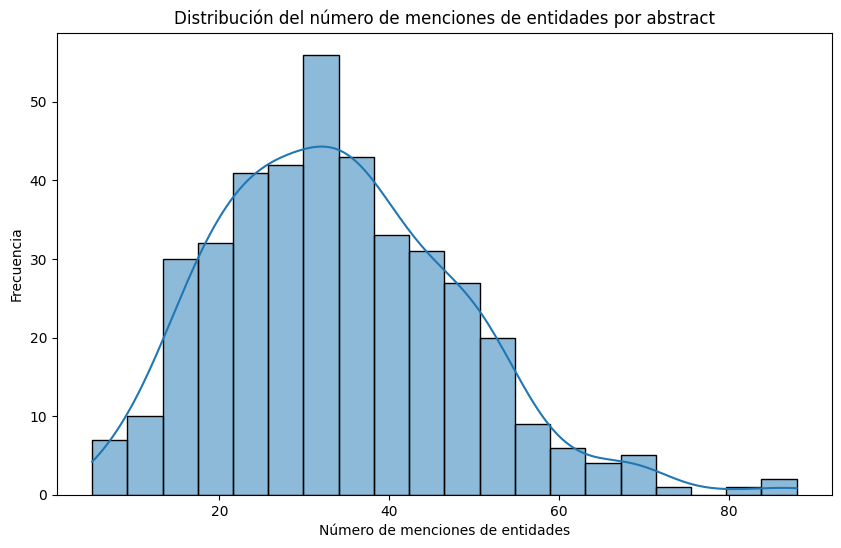

In [6]:
# cuenta de menciones de entidades por abstract
entity_counts = entities_train['abstract_id'].value_counts()

# visualizar la distribución del número de menciones por abstract
plt.figure(figsize=(10, 6))
sns.histplot(entity_counts, bins=20, kde=True)
plt.title("Distribución del número de menciones de entidades por abstract")
plt.xlabel("Número de menciones de entidades")
plt.ylabel("Frecuencia")
plt.show()

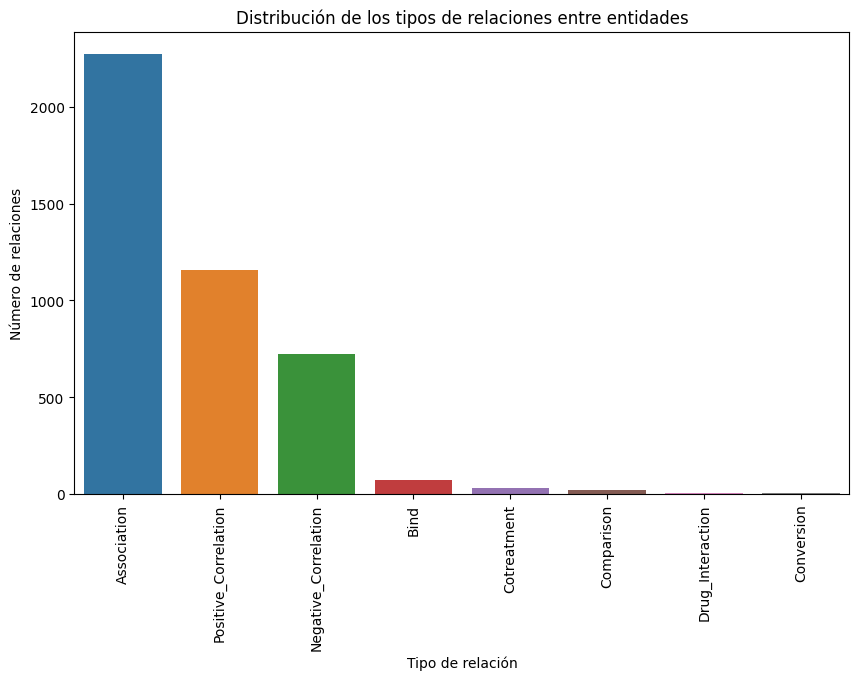

In [7]:
# Contar las relaciones por tipo
relation_types = relations_train['type'].value_counts()

# Visualizar la distribución de los tipos de relaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=relation_types.index, y=relation_types.values)
plt.title("Distribución de los tipos de relaciones entre entidades")
plt.xticks(rotation=90)
plt.xlabel("Tipo de relación")
plt.ylabel("Número de relaciones")
plt.show()

In [26]:
def frequency_analysis(df, numeric_columns, title):
    print(f"Frequency Tables for {title}:\n")
    
    # For each numeric column, calculate the frequency of unique values
    for col in numeric_columns:
        print(f"Frequency Table for {col} in {title}:")
        freq_table = df[col].value_counts().reset_index()
        freq_table.columns = [col, 'Frequency']
        print(freq_table)
        print("\n")

        # Optionally, plot the frequency distribution if the number of unique values is manageable
        if len(freq_table) <= 20:  # Plot only if unique values are <= 20
            freq_table.set_index(col).plot(kind='bar', figsize=(10, 6))
            plt.title(f'Frequency Distribution of {col} in {title}')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.show()

In [20]:
abstracts_test_numeric = ['abstract_id']
abstracts_train_numeric = ['abstract_id']
entities_train_numeric = ['id', 'abstract_id', 'offset_start', 'offset_finish']
relations_train_numeric = ['id', 'abstract_id']

In [27]:
print("Abstracts Test Dataset:")
frequency_analysis(abstracts_test, abstracts_test_numeric, "Abstracts Test Dataset")

print("\nAbstracts Train Dataset:")
frequency_analysis(abstracts_train, abstracts_train_numeric, "Abstracts Train Dataset")

print("\nEntities Train Dataset:")
frequency_analysis(entities_train, entities_train_numeric, "Entities Train Dataset")

print("\nRelations Train Dataset:")
frequency_analysis(relations_train, relations_train_numeric, "Relations Train Dataset")


Abstracts Test Dataset:
Frequency Tables for Abstracts Test Dataset:

Frequency Table for abstract_id in Abstracts Test Dataset:
    abstract_id  Frequency
0       1711760          1
1      21496008          1
2      24114426          1
3      23872883          1
4      22729903          1
..          ...        ...
95     17286451          1
96     17273972          1
97     17033974          1
98     17000021          1
99     30442153          1

[100 rows x 2 columns]



Abstracts Train Dataset:
Frequency Tables for Abstracts Train Dataset:

Frequency Table for abstract_id in Abstracts Train Dataset:
     abstract_id  Frequency
0        1353340          1
1       20846357          1
2       21126715          1
3       21080147          1
4       21070631          1
..           ...        ...
395     17166870          1
396     17151160          1
397     17083016          1
398     17074608          1
399     30836660          1

[400 rows x 2 columns]



Entities Train Dataset:
F